In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Mount GDrive

from google.colab import drive

try:
    drive.mount('/content/gdrive/')
except:
    drive.mount("/content/gdrive/", force_remount=True)
    print('drive mounted')

# Define the root path
rootpath = '/content/gdrive/My Drive/Capstone Project ML'

# Change the current working directory to the root path
os.chdir(rootpath)


Ravdess = 'ravdess'

Crema = 'Crema-D'


Mounted at /content/gdrive/


In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' +  dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)



In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


In [ ]:
total_data = pd.concat([Crema_df, Ravdess_df])

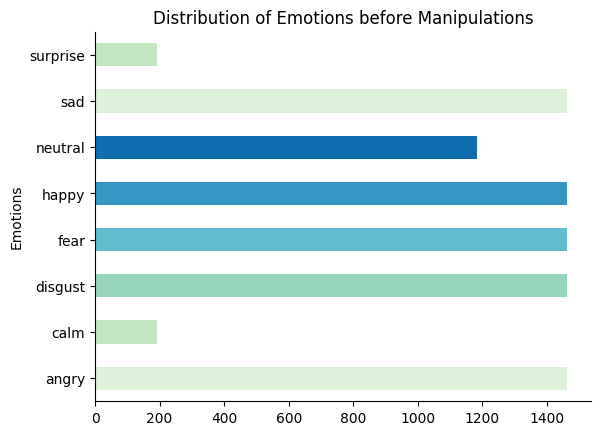

In [ ]:
plt.title('Distribution of Emotions before Manipulations')
total_data.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('GnBu'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Remove rows with 'surprise' emotion
total_dataset = total_data[total_data['Emotions'] != 'surprise']

# Rename 'calm' rows to 'neutral'
total_dataset.loc[total_dataset['Emotions'] == 'calm', 'Emotions'] = 'neutral'

total_dataset.to_csv("total_dataset.csv",index=False)

# We can use this smaller dataset to trouble shoot
subset_total_dataset = total_dataset.head(20)
subset_total_dataset

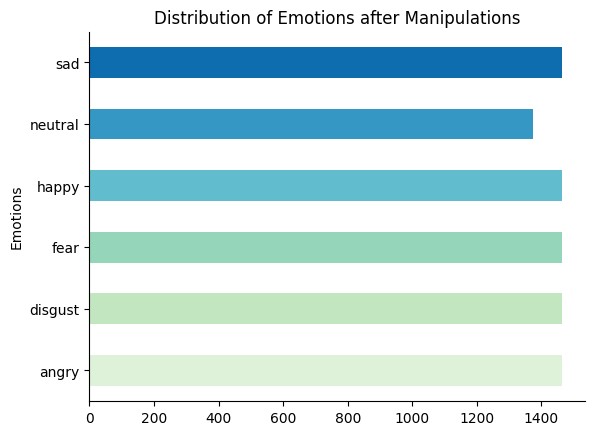

In [ ]:
plt.title('Distribution of Emotions after Manipulations')
total_dataset.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('GnBu'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#MFCCs Features

In [ ]:
# This code is for extracting mfccs features. I don't recommend running it, there is a saved csv file in google drive. If you do run it, it will take around 36 mins.
MFCCs_list = []

for index, row in total_dataset.iterrows():
    # Load the .wav file
    try:
      file_path = row['Path']
      audio, sample_rate = librosa.load(file_path)

      # Extract MFCC features
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

      # Flatten the MFCC features and calculate the mean
      mfccs_mean = mfccs.mean(axis=1)

      # Create a dictionary to store the features
      features = {'Emotion': row['Emotions']}
      for i, mfcc_value in enumerate(mfccs_mean):
          features[f'MFCC_{i+1}'] = mfcc_value

      MFCCs_list.append(features)
    except Exception as e:
        print(f"Error processing file: {file_path}. Error: {e}")

# Create a DataFrame from the list of features
MFCCs_df = pd.DataFrame(MFCCs_list)

MFCCs_df


,Emotion,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,fear,-311.310944,80.464165,-4.113749,36.594761,-12.059236,8.862662,-17.195938,9.902398,-7.331563,12.745308,7.748431,10.067600,17.379269
1,angry,-327.749451,113.807762,-3.075910,41.587761,-18.002378,13.929490,-5.135050,7.116399,-9.822118,2.880736,-0.954140,0.468127,4.163919
2,happy,-372.261475,123.074554,8.858895,48.145008,-4.272263,13.564652,-13.330286,10.241986,-10.191195,0.047539,-4.466393,-6.580404,4.533807
3,neutral,-415.926392,117.393661,11.730679,64.277260,-11.827156,28.395706,-24.674046,16.144646,-10.402498,6.062081,-0.050691,-1.687410,9.578014
4,disgust,-364.843506,97.669968,2.563177,53.843594,-11.676711,28.449705,-20.155310,14.319797,-8.418567,7.009809,-0.819130,-1.876718,8.616802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8685,neutral,-711.297791,67.526596,12.455447,23.878843,8.070921,4.472210,7.304467,-3.989563,-1.406344,-1.467055,1.698641,-6.839279,0.878537
8686,disgust,-628.387512,47.702229,11.173059,12.239254,4.338355,-4.294918,-4.679064,-6.931329,-1.508175,-0.564752,-4.150143,4.714321,-3.804058
8687,disgust,-646.569885,73.460701,4.792179,15.512630,4.200931,-5.265332,-6.212433,-6.456671,-1.343032,-2.174677,-2.479818,1.044854,-2.918449
8688,disgust,-605.901001,51.231045,4.720355,12.248284,2.849711,-0.352826,-2.147098,-14.420915,-2.535731,1.679313,-0.761943,3.042430,1.143436


In [ ]:
# Saving mfccs results as csv file
MFCCs_df.to_csv('MFCCs_df.csv', index = True)


#Zero-Crossing Rate

In [ ]:
#Extracting Zero-Crossing Rate
zero_crossing_rates = []

for index, row in total_dataset.iterrows():
    file_path = row['Path']
    signal, sr = librosa.load(file_path)

    # Calculate the Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(signal)[0, :].mean()
    features = {'Emotion': row['Emotions'], 'ZCR': zcr}
    zero_crossing_rates.append(features)

# Create a DataFrame from the list of features
zero_crossing_rates_df = pd.DataFrame(zero_crossing_rates)

# Saving the results as csv file
zero_crossing_rates_df.to_csv('zero_crossing_rates_df.csv', index = True)

#Chroma Features

In [ ]:
#Extracting Chroma features
chroma_features_list = []

for index, row in total_dataset.iterrows():
    file_path = row['Path']
    signal, sr = librosa.load(file_path)

    # Calculate the chromagram
    chroma_stft_matrix = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=512)

    # Calculate mean for each chroma across all frames
    chroma_stft_mean = np.mean(chroma_stft_matrix, axis=1)

    # Create a dictionary to store chroma features and corresponding emotion
    chroma_features = {'Emotion': row['Emotions']}
    for i, chroma_mean in enumerate(chroma_stft_mean):
        chroma_features[f'Chroma_{i+1}'] = chroma_mean

    chroma_features_list.append(chroma_features)

# Create a DataFrame from the list of features
chroma_features_df = pd.DataFrame(chroma_features_list)

# Saving the results as csv file
chroma_features_df.to_csv('chroma_features_df.csv', index=True)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


#Pitch Feature

In [ ]:
# Initialize an empty list to store dictionaries
pitch_list = []

for index, row in total_dataset.iterrows():
    try:
        file_path = row['Path']
        print(f"Processing file: {file_path}")  # Print file path for debugging

        # Load the .wav file
        y, sr = librosa.load(file_path)

        # Extract pitch
        pitch, mag = librosa.core.piptrack(y=y, sr=sr)

        # Compute the mean pitch excluding unvoiced segments
        mean_pitch = np.mean(pitch[pitch > 0])

        # Append the features to the list as a dictionary
        pitch_list.append({'Emotion': row['Emotions'], 'Pitch': mean_pitch})
    except Exception as e:
        print(f"Error processing file: {file_path}. Error: {e}")

# Convert the list of dictionaries to a DataFrame
pitch_df = pd.DataFrame(pitch_list)

# Save the DataFrame to a CSV file
pitch_df.to_csv('pitch_features.csv', index=True)